# Problem Statement
------------------------------------------------------------------------
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

------------------------------------------------------------------------

In [50]:
#imports

from pathlib import Path
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

from tensorflow.keras.preprocessing.image import load_img

* Data Reading/Data Understanding → Defining the path for train and test

In [2]:
train_data = Path('/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train')
test_data = Path('/content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')

* Dataset Creation→ Create train & validation dataset from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180.

In [51]:
batch_size=32
image_size=(180,180)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_data,
    validation_split = 0.2,
    batch_size=32,
    image_size=(180,180),
    subset='training',
    label_mode='categorical',
    seed=123)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_data,
    validation_split = 0.2,
    batch_size=32,
    image_size=(180,180),
    subset='validation',
    label_mode='categorical',
    seed=123)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.
Found 2239 files belonging to 9 classes.
Using 447 files for validation.


Dataset visualisation → Create a code to visualize one instance of all the nine classes present in the dataset

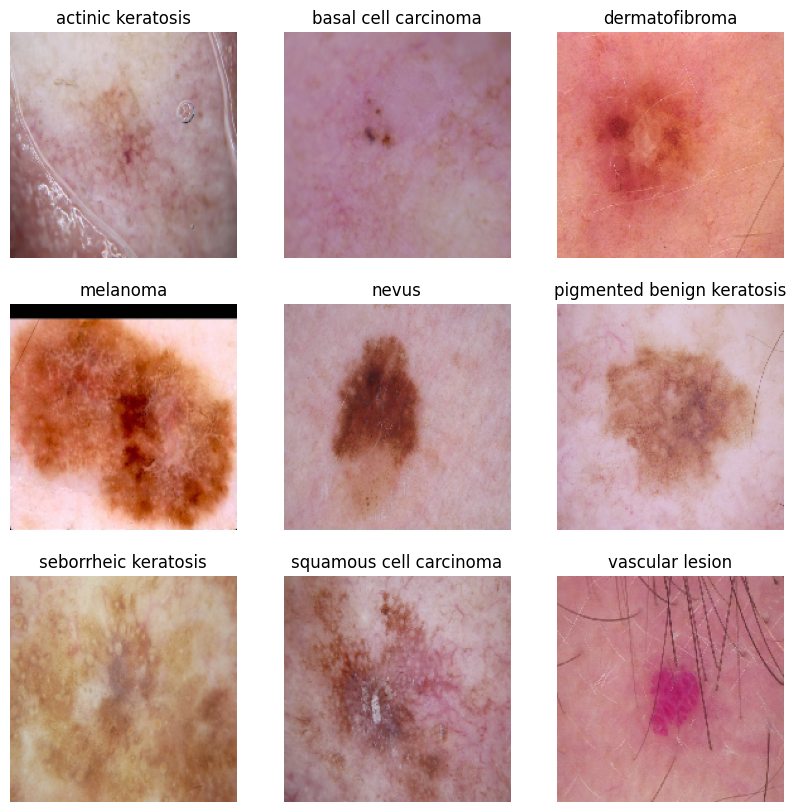

In [52]:
class_names = train_dataset.class_names

plt.figure(figsize=(10,10))
for e,i in enumerate(class_names):
    plt.subplot(3,3,e+1)
    plt.imshow(load_img(f"{train_data}/{i}/{os.listdir(str(train_data)+'/'+i)[0]}",target_size=(180,180)))
    plt.title(i)
    plt.axis("off")


In [53]:
# Images of each kind in dataset :

image_number_list = []
for item in class_names:
    image_number_list.append(len(os.listdir(f"{str(train_data)}/{item}")))

number_of_images = pd.DataFrame(image_number_list,index=class_names,columns=['Number of images'])
number_of_images

,Number of images
actinic keratosis,114
basal cell carcinoma,376
dermatofibroma,95
melanoma,438
nevus,357
pigmented benign keratosis,462
seborrheic keratosis,77
squamous cell carcinoma,181
vascular lesion,139


It is evident that the dataset exhibits a class imbalance. To address this issue, we will employ data augmentation strategies. However, as per the project requirements, we will first train a model using the imbalanced dataset. After training, we will validate the model and then proceed with the augmentation phase.

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Model Building & training :
* Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1).
*   Choose an appropriate optimiser and loss function for model training
* Train the model for ~20 epochs
* Write your findings after the model fit. You must check if there is any evidence of model overfit or underfit.




In [7]:
target_labels = 9

model = Sequential()
model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model.add(layers.Flatten())

#First Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Second Dense Layer
model.add(layers.Dense(len(class_names),activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,276,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,301,673 (12.59 MB)

 Trainable params: 3,301,673 (12.59 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
epochs = 20
history = model.fit(train_dataset,validation_data=validation_dataset,epochs=epochs)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 465s 3s/step - accuracy: 0.1943 - loss: 2.0830 - val_accuracy: 0.4385 - val_loss: 1.7397
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.3822 - loss: 1.7187 - val_accuracy: 0.4989 - val_loss: 1.4808
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.4659 - loss: 1.4932 - val_accuracy: 0.5280 - val_loss: 1.4155
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5083 - loss: 1.3997 - val_accuracy: 0.5145 - val_loss: 1.3416
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step - accuracy: 0.5560 - loss: 1.2758 - val_accuracy: 0.5011 - val_loss: 1.3757
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 61s 1s/step - accuracy: 0.5897 - loss: 1.1895 - val_accuracy: 0.5034 - val_loss: 1.4049
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 65s 1s/step - accuracy: 0.5949 - loss: 1.1905 - val_accuracy: 0.5034 - val_loss: 1.3827
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6213 - loss: 1.0643 - val_accuracy: 0.5235 - val_loss

Observation:
* Training Accuracy: 82.45%
* Validation Accuracy: 52.57%
* Training Loss: 0.4959
* Validation Loss: 2.1813

Analysis:
1. The training accuracy is significantly higher (82.45%) compared to the validation accuracy (52.57%). This indicates that the model performs well on the training set but struggles to generalize on unseen data.
2. The training loss is low (0.4959), whereas the validation loss is high (2.1813). This further supports the observation of poor generalization.
3. The large gap between training and validation accuracy, combined with the validation loss being much higher than the training loss, indicates that the model is overfitting to the training data.

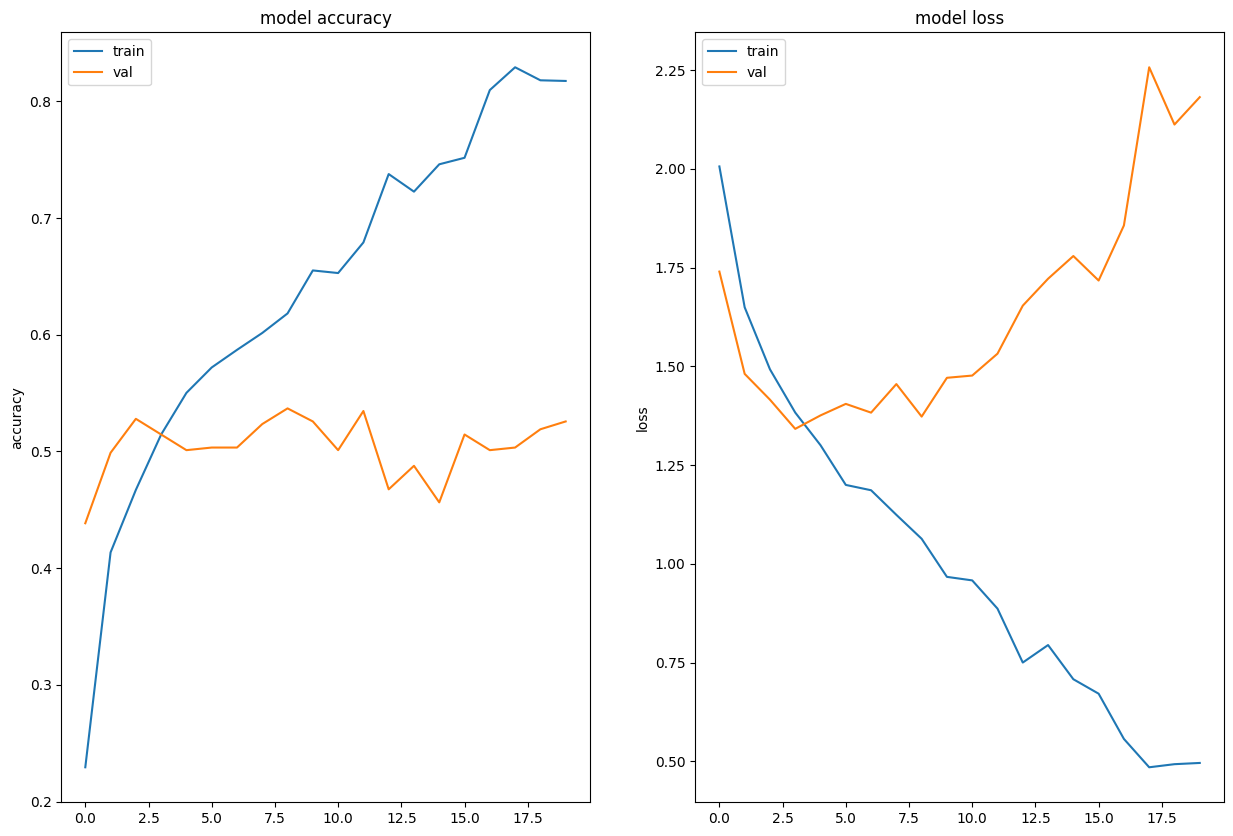

In [11]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

To resolve this overfitting issue we used techniques such as rotation and zooming adjustments to artificially increase the size and diversity of the training data.

# Model Building & training on the augmented data :
* Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model rescale images to normalize pixel values between (0,1).
* Choose an appropriate optimiser and loss function for model training
* Train the model for ~20 epochs
* Write your findings after the model fit, see if the earlier issue is resolved or not?

In [18]:
augmentation_data = Sequential([
    RandomFlip("horizontal", input_shape=(180, 180, 3)),
    RandomRotation(0.1),
    RandomZoom(0.1),
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


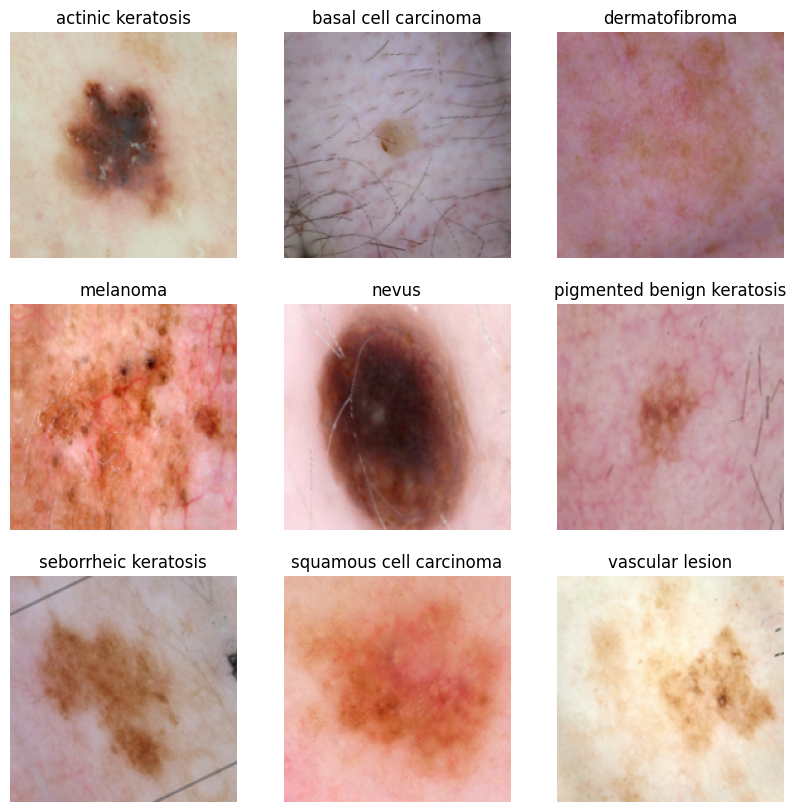

In [34]:
plt.figure(figsize=(10, 10))

for images, labels in train_dataset.take(1):
    for i in range(9):
        augmented_images = augmentation_data(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.title(class_names[i])
        plt.axis("off")

In [39]:
target_labels = 9

model = Sequential()
model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model.add(layers.Flatten())

#First Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Second Dense Layer
model.add(layers.Dense(len(class_names),activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [57]:
# Ensure the dataset returns batches of images and labels
def preprocess_with_augmentation(image, label):
    image = augmentation_data(image, training=True)  # Apply augmentation
    return image, label

train_dataset_aug = (
    train_dataset
    .map(preprocess_with_augmentation)  # Apply preprocessing
    # .batch(32)  # Batch the data
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # Optimize pipeline
)

# validation_dataset = validation_dataset.batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [60]:
for images, labels in train_dataset_aug.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")


Image batch shape: (32, 180, 180, 3)
Label batch shape: (32, 9)


In [59]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [64]:
epochs = 20
history = model.fit(train_dataset_aug,validation_data=validation_dataset,epochs=epochs)

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step - accuracy: 0.2343 - loss: 2.0192 - val_accuracy: 0.3356 - val_loss: 1.8241
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.3664 - loss: 1.7773 - val_accuracy: 0.5257 - val_loss: 1.5347
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.4770 - loss: 1.5314 - val_accuracy: 0.4855 - val_loss: 1.4680
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.4542 - loss: 1.5355 - val_accuracy: 0.4899 - val_loss: 1.4891
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 97s 2s/step - accuracy: 0.5115 - loss: 1.3660 - val_accuracy: 0.5391 - val_loss: 1.3794
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.5410 - loss: 1.3112 - val_accuracy: 0.5436 - val_loss: 1.3695
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.5593 - loss: 1.2691 - val_accuracy: 0.4922 - val_loss: 1.4506
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.5359 - loss: 1.3201 - val_accuracy: 0.5459 - val_l

Observation:
* Training Accuracy: 59.47%
* Validation Accuracy: 53.24%
* Training Loss: 1.0854
* Validation Loss: 1.3189

Analysis:
1. Data augmentation has resolved the overfitting issue observed in the previous model, as the training and validation accuracy are closer. However, the overall accuracy remains moderate, and the validation loss stabilizes at a relatively high value, suggesting room for further improvement.
2. It is highly likely that the issue is caused by class imbalance in the dataset. This will be addressed in the next step by handling the class imbalance, followed by building a new model.

Class distribution: Examine the current class distribution in the training dataset
- Which class has the least number of samples?
- Which classes dominate the data in terms of the proportionate number of samples?

In [79]:
# Images of each kind in dataset :

image_number_list = []
for item in class_names:
    image_number_list.append(len(os.listdir(f"{str(train_data)}/{item}")))

number_of_images = pd.DataFrame(image_number_list,index=class_names,columns=['Number of images'])
number_of_images

,Number of images
actinic keratosis,115
basal cell carcinoma,377
dermatofibroma,96
melanoma,439
nevus,358
pigmented benign keratosis,463
seborrheic keratosis,78
squamous cell carcinoma,182
vascular lesion,140


* The number of images varies significantly across classes, ranging from 78 (seborrheic keratosis) to 463 (pigmented benign keratosis).
* The largest class, pigmented benign keratosis, has nearly six times more samples than the smallest class, seborrheic keratosis.

The dataset exhibits significant class imbalance, which can lead to the model performing well on the dominant classes while struggling with underrepresented ones. Addressing this imbalance is crucial for ensuring fair and accurate predictions across all categories.

--------------------------------------------------------------------------

# Model Building & training on the rectified class imbalance data :
* Create a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescale images to normalize pixel values between (0,1).
* Choose an appropriate optimiser and loss function for model training
* Train the model for ~30 epochs
* Write your findings after the model fit, see if the issues are resolved or not?

We will use the Augmentor library to address this issue by generating additional samples for underrepresented classes, ensuring a more balanced dataset for training.

In [65]:
!pip install Augmentor

In [67]:
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(f"{train_data}/{i}")
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E1C248FC880>: 100%|██████████| 500/500 [00:28<00:00, 17.75 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E1C24878EE0>: 100%|██████████| 500/500 [00:29<00:00, 17.13 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E1C25975E70>: 100%|██████████| 500/500 [00:29<00:00, 16.81 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E1C1A3D9D50>: 100%|██████████| 500/500 [02:04<00:00,  4.02 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7E1C25947640>: 100%|██████████| 500/500 [02:21<00:00,  3.55 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E1C248C5A20>: 100%|██████████| 500/500 [00:29<00:00, 16.99 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E1C29827250>: 100%|██████████| 500/500 [00:55<00:00,  9.09 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E1C25976EF0>: 100%|██████████| 500/500 [00:28<00:00, 17.28 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E1C2597C490>: 100%|██████████| 500/500 [00:30<00:00, 16.56 Samples/s]


In [70]:
batch_size=32
image_size=(180,180)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_data,
    validation_split = 0.2,
    batch_size=32,
    image_size=(180,180),
    subset='training',
    label_mode='categorical',
    seed=123)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_data,
    validation_split = 0.2,
    batch_size=32,
    image_size=(180,180),
    subset='validation',
    label_mode='categorical',
    seed=123)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.
Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [72]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [73]:
target_labels = 9

model = Sequential()
model.add(layers.Rescaling(1./255,input_shape=(180,180,3)))

#First Convulation layer
model.add(layers.Conv2D(16,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model.add(layers.Flatten())

#First Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Second Dense Layer
model.add(layers.Dense(len(class_names),activation='softmax'))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [74]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [75]:
epochs = 35
history = model.fit(train_dataset,validation_data=validation_dataset,epochs=epochs)

Epoch 1/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 256s 1s/step - accuracy: 0.2403 - loss: 2.0427 - val_accuracy: 0.4417 - val_loss: 1.4828
Epoch 2/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.4462 - loss: 1.4704 - val_accuracy: 0.5360 - val_loss: 1.2405
Epoch 3/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.5206 - loss: 1.2792 - val_accuracy: 0.5605 - val_loss: 1.1793
Epoch 4/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.5668 - loss: 1.1653 - val_accuracy: 0.6050 - val_loss: 1.0849
Epoch 5/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.6385 - loss: 0.9845 - val_accuracy: 0.6050 - val_loss: 1.1509
Epoch 6/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.6984 - loss: 0.8546 - val_accuracy: 0.6407 - val_loss: 1.1120
Epoch 7/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - accuracy: 0.7136 - loss: 0.7905 - val_accuracy: 0.7238 - val_loss: 0.9158
Epoch 8/35
169/169 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.8046 - loss: 0.5425 - val_accu

# Observtions
* Training Accuracy: 95.44%
* Training Loss: 0.1214
* Validation Accuracy: 77.06%
* Validation Loss: 1.3919

The model shows excellent training accuracy (95.44%) with very low training loss (0.1214), indicating that it has learned the features from the training data very well.

There is a noticeable gap between training and validation accuracy, indicating mild overfitting, though the gap is much smaller than earlier.
The model is likely overfitting to the training data but still performs reasonably well on the validation data.

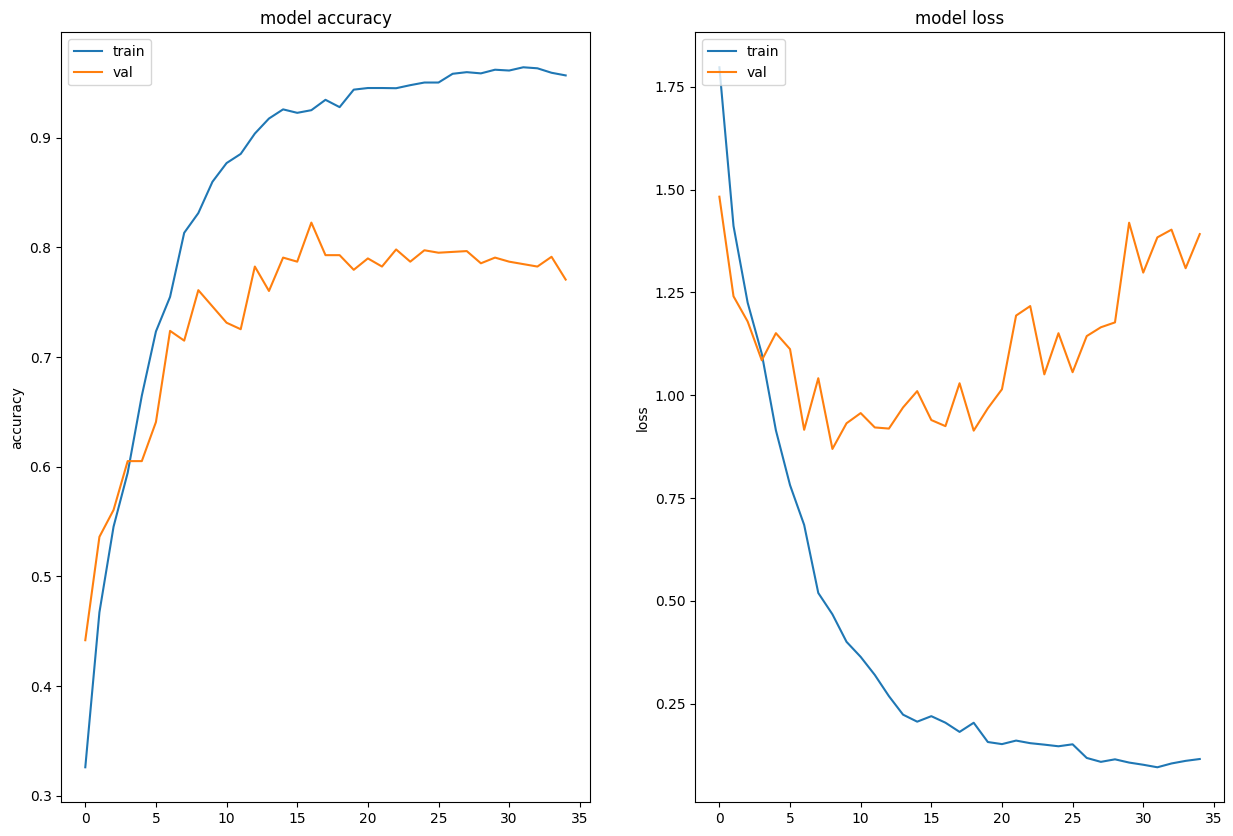

In [76]:
plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

#Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')

#Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Model Evalution

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Actual Class: basal cell carcinoma
Predicted Class: basal cell carcinoma


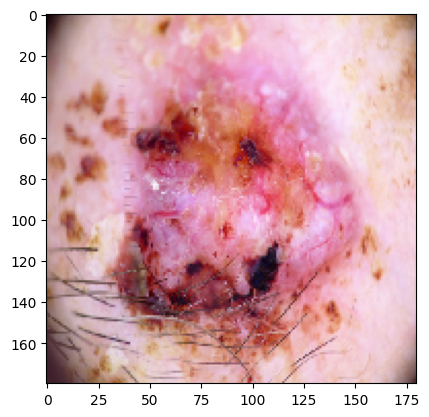

In [82]:
from tensorflow.keras.preprocessing.image import load_img
from glob import glob

image_path_test = os.path.join(test_data, class_names[1], '*')
test_image = glob(image_path_test)
test_image = load_img(test_image[-1], target_size=(180, 180, 3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image, axis=0)
predicted = model.predict(img)
predicted = np.argmax(predicted)
predicted_class = class_names[predicted]
print("Actual Class: " + class_names[1] +'\n'+ "Predicted Class: " + predicted_class)